In [1]:
using Logging
Logging.disable_logging(LogLevel(3))

using LinearAlgebra
using SparseArrays
using KrylovKit
using FFTW
using Plots
using Colors
Threads.nthreads()


(process:18768): GLib-GIO-WARNING **: 09:05:25.125: Unexpectedly, UWP app `draw.io.draw.ioDiagrams_16.5.1.0_x64__1zh33159kp73c' (AUMId `draw.io.draw.ioDiagrams_1zh33159kp73c!draw.io.draw.ioDiagrams') supports 2 extensions but has no verbs


4

In [20]:
function hamiltonian_2D(xmin, xmax, ymin, ymax, Δx, Δx², Δy, Δy², N, N², V, m, M, ħ)
    # BLOC EXTRA-DIAGONAL
    J = -ħ^2*  1/(2*M*Δy²)*sparse(I,N,N);
    
    # BLOC DIAGONAL
    diag = -(1/(m*Δx²)+1/(M*Δy²))*ones(Float64,N);  # vecteur de la diagonale RQ: le *2 sur la diagonale du laplacien discret se simplifie avec 1/2m
    extra_diag = 1/(2*m*Δx²)*ones(Float64,N-1); # vecteur de la sur- et sous-diagonale remplies de 1

    T = -ħ^2*  SymTridiagonal(diag, extra_diag);  # matrice des blocs diagonaux, qui est tridiagonale symétrique

    # assemblage du laplacien
    Λ = spzeros(N²,N²);
    @views for i in 1:N
        Λ[1+(i-1)*N:i*N,1+(i-1)*N:i*N] .= T[:,:]
    end
    
    @views for i in 1:N-1
        Λ[1+(i-1)* N : i    *N, 1+(i)  *N :  (i+1)*N] .= J[:,:] # remplissage blocs extradiag supérieurs
        Λ[1+(i)  * N : (i+1)*N, 1+(i-1)*N :      i*N] .= J[:,:] # remplissage blocs extradiag inférieurs
    end

    V = Diagonal(reshape(V,N²)); # a priori inutile de convertir en sparse avant

    H = Λ+V;
    H,Λ,V # opérateurs (matrices de taille N²×N²)
end


function hamiltonian_1D(dmin, dmax, Δd², N, V, m, ħ)
    Λ = -ħ^2*    1/(Δd²*2*m)*SymTridiagonal(-2*ones(Float64,N),ones(Float64,N-1));
    V = sparse(Diagonal(V)); # V_fun.(LinRange(xmin,xmax,N)) pour créer l'argument
    H = Λ + V; 
    H,Λ,V
end

hamiltonian_1D (generic function with 1 method)

### Définition du problème et de ses paramètres
On met le hamiltonien original

\begin{equation}
 -\frac{1}{2m} \frac{\partial^2}{\partial x^2} - \frac{1}{2M} \frac{\partial^2}{\partial y^2} + V(x,y)
\end{equation}

sous la forme 

\begin{equation}
    H = V(x_0,y_0) + H_x +H_y +W
\end{equation}
où
\begin{equation}
H_y =  - \frac{1}{2m} \frac{\partial^2}{\partial y^2} + \frac{1}{2} \frac{\mathrm{d}^2 E_0}{\mathrm{d}y^2}(y_0)(y-y_0)^2
\end{equation}

\begin{equation}
H_x = - \frac{1}{2M} \frac{\partial^2}{\partial x^2} + \frac{1}{2}\frac{\partial^2 V}{\partial x^2} (x_0,y_0) (x-x_0)^2
\end{equation}

et enfin le troisième terme est la perturbation
\begin{equation}
W = \frac{\partial V}{\partial y}(x,y_0)(y-y_0) + \frac{1}{2}\frac{\partial^2V}{\partial y^2}(x,y_0)(y-y_0)^2 + \underset{y\rightarrow y_0}{o} (y-y_0)^2  - \frac{1}{2} \frac{\mathrm{d}^2 E_0}{\mathrm{d}y^2}(y_0)(y-y_0)^2   + \underset{x\rightarrow x_0}{o} (x-x_0)^2
\end{equation}

In [16]:
function decompose_hamiltonian(xmin, xmax, ymin, ymax, N, V_fun, m, M, ħ, kdim)
    Δx = (xmax-xmin)/(N-1);
    Δy = (ymax-ymin)/(N-1);
    Δx² = Δx*Δx;
    Δy² = Δy*Δy;
    N² = N*N;

    # CONSTRUCTION DE LA MESHGRID
    G = zeros(Float64,2,N,N); # meshgrid: deux coordonnées x et y sur la première dimension; julia stocke la première dimension de manière contiguë d'abord
    ys = ymin:Δy:ymax;        # cf https://discourse.julialang.org/t/meshgrid-function-in-julia/48679/5
    xs = xmin:Δx:xmax;
    G = zeros(Float64,2,N,N); # on pourrait aussi concaténer, voir https://docs.julialang.org/en/v1/manual/arrays/
    G[1,:,:] = ones(N)' .* ys;
    G[2,:,:] = xs' .* ones(N);
    X = @view G[1,:,:];
    Y = @view G[2,:,:];
    V = zeros(N,N); # potentiel original en matrice (pas opérateur)

    # CONSTRUCTION DU POTENTIEL ET DU HAMILTONIEN
    @. V = V_fun(X, Y); # calcul du potentiel sur la grille
    H, Λ, ~ =  hamiltonian_2D(xmin, xmax, ymin, ymax, Δx, Δx², Δy, Δy², N, N², V, m, M, ħ);
    lowest_energies_y = zeros(N);

    # RECHERCHE DU y₀
    # lower_eigenvec_y = zeros(N,N); # premier axe: y, second axe x
    Λₓ = -ħ^2*    1/(Δx²*2*m)*SymTridiagonal(-2*ones(Float64,N),ones(Float64,N-1));  # laplacien sur l'axe x
    Vₓ = spzeros(N); # potentiel en x
    Base.Threads.@threads for j in 1:N # threads cf https://thomaswiemann.com/assets/teaching/Fall2021-Econ-31720/Econ_31720_discussion_6.pdf
        # Hₓ,~,~ = hamiltonian_1D(xmin, xmax, Δx², N, V[:,j], m, ħ); # selon Ox
        Vₓ = sparse(Diagonal(V[:,j]))
        # ϕ₀ = rand(Float64, N);
        vals, ~, infos = KrylovKit.eigsolve(Λₓ+Vₓ, N, 1, :SR, krylovdim=kdim); # H, x₀, how many (::Int), which, krylovdim ou bien remplacer x₀ par un entier qui est la dimenson
        lowest_energies_y[j]     = infos.converged==1 ? vals[1]    : NaN;  # on récupère l'énergie  propre du niveau fondamental sur la tranche à y fixé
        # lower_eigenvec_y[j,:]   .= infos.converged==1 ? vecs[1][:] : NaN; # on récupère le vecteur propre du niveau fondamental sur la tranche à y fixé
    end  

    # CALCUL DES RAIDEURS
    E₀_at_y₀, ind_y₀ = findmin(lowest_energies_y);
    y₀               = ind_y₀*Δy + ymin;
    ∂²yyE₀_at_y₀     = 1/(Δy)^2 * dot([−1/12, 4/3, −5/2, 4/3, −1/12], view(lowest_energies_y, ind_y₀-2:ind_y₀+2));  # on calcule la dérivée seconde  à l'ordre 4 par rapport à y de E₀ en y₀
    V_at_x₀,  ind_x₀ = findmin(view(V, :, ind_y₀));

    x₀               = ind_x₀*Δy + xmin;
    ∂yV_at_x₀y₀      = 1/Δy     * dot([+1/12, −2/3,  0.,  2/3, −1/12], view(V, ind_x₀,            ind_y₀-2:ind_y₀+2));  # on calcule la dérivée première à l'ordre 4 par rapport à x du potentiel en x₀,y₀ # doit être nulle !!
    ∂²xxV_at_x₀y₀    = 1/(Δx)^2 * dot([−1/12,  4/3, −5/2, 4/3, −1/12], view(V, ind_x₀-2:ind_x₀+2, ind_y₀));             # on calcule la dérivée seconde  à l'ordre 4 par rapport à x du potentiel en x₀,y₀
    ∂²yyV_at_x₀y₀    = 1/(Δy)^2 * dot([−1/12,  4/3, −5/2, 4/3, −1/12], view(V, ind_x₀,            ind_y₀-2:ind_y₀+2));  # on calcule la dérivée seconde  à l'ordre 4 par rapport à y du potentiel en x₀,y₀

    kx = ∂²xxV_at_x₀y₀; # constante de raideur sur l'axe (Ox) pour le hamiltonien non perturbé
    ky = ∂²yyE₀_at_y₀;  # constante de raideur sur l'axe (Oy) pour le hamiltonien non perturbé

    # HAMILTONIEN NON PERTURBE H₀
    H₀ = spzeros(N²,N²);
    H₀ .+= Λ;
    V₀ = zeros(N,N); # potentiel harmonique
    @. V₀ = .5*∂²xxV_at_x₀y₀*(X.-x₀) .^2 + .5*∂²yyE₀_at_y₀*(Y.-y₀) .^2;
    H₀ .+= Diagonal(reshape(V₀,N²));
    
    # PERTURBATION Ŵ
    W = spzeros(N²,N²);

    # calcul du terme en ∂V/∂y de la perturbation
#=  V̂y = fft(V', (1,)); # direction selon (Oy) avec la transposée car column-major
    κ = fftshift(2*π/(ymax-ymin) * (Vector(Base.OneTo(N)) .- N÷2));
    dV̂y = im * κ .* V̂y; # piecewise column-major product par défaut
    ∂Vy = real(ifft(dV̂y, (1,)))'; # matrice des dérivées selon x du potentiel et on retranspose =#

    ∂Vy = zeros(N,N);
    # correction sur les bords du phénomène de Gibbs
    for i in 1:N # parcours sur x
      for j in 1:N
        if j<3
          @views ∂Vy[i,j]     = 1/Δy * dot([−25/12 4 −3 4/3 −1/4],   V[i,j:j+4]); # forward  vers ymin
        elseif j>N-2 
          @views ∂Vy[i,j] = 1/Δy * dot([1/4 -4/3 3 -4 25/12],    V[i,j-4:j]); # backward vers ymax
        else
          @views ∂Vy[i,j]     = 1/Δy * dot([+1/12, −2/3,  0.,  2/3, −1/12],   V[i,j-2:j+2]); # centered elsewhere
        end
      end
    end

    

    pertV_o1  = ∂Vy .* (Y.-y₀);
    pertV_o2  = .5  * (∂²yyV_at_x₀y₀ - ∂²yyE₀_at_y₀) .* (Y .- y₀) .^2;
    Vₚ = pertV_o1 + pertV_o2;
    W += Diagonal(reshape(Vₚ, N²)); # à optimiser pour la contamination (vecteur au lien d'une matrice creuse)
                                    # pour le moment je laisse comme ça, ça colle mieux avec le type réel de W
    
    return H, V, Λ, H₀, V₀, W, Vₚ, kx, ky, ∂²yyV_at_x₀y₀, lowest_energies_y, ind_y₀, y₀, ind_x₀, x₀, Δx, Δy, ∂Vy
end

decompose_hamiltonian (generic function with 1 method)

In [17]:
ϕ₀ = rand(Float64, 10);
ϕ = copy(ϕ₀);
vals, vecs, infos = KrylovKit.eigsolve(rand(10,10), 10, 1, :SR, krylovdim=20);
ϕ == ϕ₀

true

### 1) Création d'un problème avec un potentiel

In [18]:
# A = rand(2,2);
A = Matrix{Float64}(I, 2,2);
A = [0.7 0.4; 0.4 0.7];
SP = .5*A'*A;

xmin=-5.; xmax=5.; ymin=-5.; ymax=5.; N=100; m=1.; M=3.; ω=1.; ħ=1.; kdim=20; # augmenter kdims quand N est grand: pour N=200, prendre kdim=50

function V_func(x,y)
     return .5*m*ω^2*dot([x, y], SP*[x, y]) #  -3/(.5+sqrt(.05(x+2.5)^2+.05(y-2.6)^2)); # somme d'un oscillateur et d'un potentiel coulombien 
end

V_func (generic function with 1 method)

### 2) Décomposition (approchée) d'un hamiltonien perturbé $H_0$ et d'une correction $\hat{W}$.
Remarque: lorsqu'on plot on doit transposer car https://discourse.julialang.org/t/hi-evrybody-im-trying-to-overlay-a-scatter-plot-with-a-heatmap-using-plots-jl-bu/56067


 y₀ minimise l'énergie de l'état fon damental du hamiltonien pris sur l'axe y=y₀ (la tranche), et x₀ minimise le potentiel sur l'axe y=y₀

  3.329140 seconds (8.31 M allocations: 501.979 MiB, 3.87% gc time, 94.11% compilation time)
kx=0.325 
ky=0.0838
x₀=0.0505
y₀=0.1515


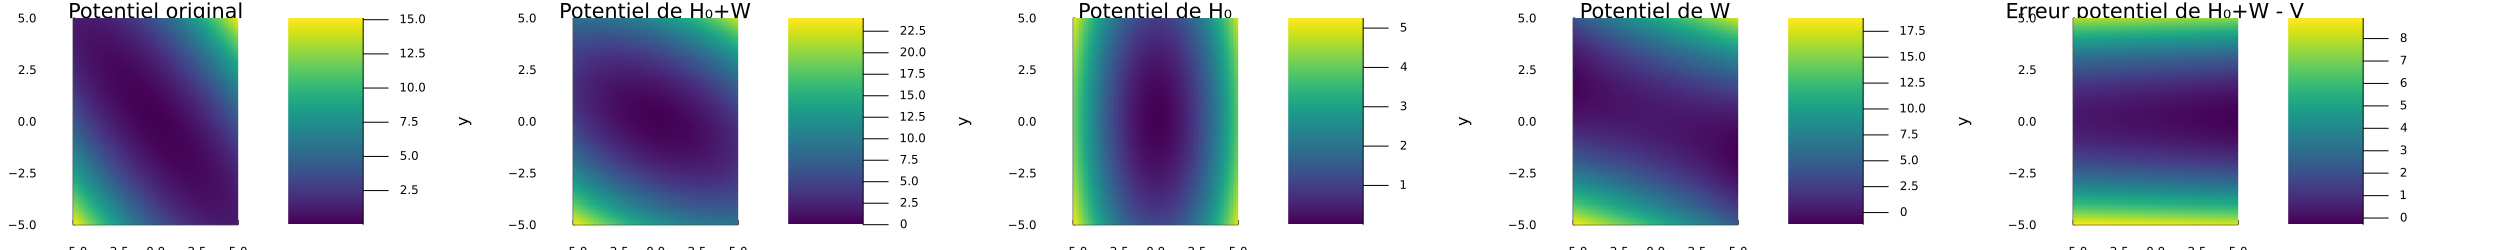

In [21]:
@time H, V, Λ, H₀, V₀, W, Vₚ, kx, ky, ∂²yyV_at_x₀y₀, lowest_energies_y, ind_y₀, y₀, ind_x₀, x₀, Δx, Δy, ∂Vy =  decompose_hamiltonian(xmin, xmax, ymin, ymax, N, V_func, m, M, ħ, kdim);
println("kx=$(round(kx,digits=4)) \nky=$(round(ky,digits=4))\nx₀=$(round(x₀,digits=4))\ny₀=$(round(y₀,digits=4))")

plot_V  = heatmap(LinRange(xmin,xmax,N),LinRange(ymin,ymax,N), V', xlabel="x", ylabel="y", xlims = (xmin,xmax), ylims=(ymin,ymax), color=cgrad(:viridis, rev=false), title = "Potentiel original")
plot_V₀ = heatmap(LinRange(xmin,xmax,N),LinRange(ymin,ymax,N), V₀', xlabel="x", ylabel="y", xlims = (xmin,xmax), ylims=(ymin,ymax), color=cgrad(:viridis, rev=false), title = "Potentiel de H₀")
plot_Vₚ = heatmap(LinRange(xmin,xmax,N),LinRange(ymin,ymax,N), Vₚ', xlabel="x", ylabel="y", xlims = (xmin,xmax), ylims=(ymin,ymax), color=cgrad(:viridis, rev=false), title = "Potentiel de W")
plot_V_approx = heatmap(LinRange(xmin,xmax,N),LinRange(ymin,ymax,N), V₀'+Vₚ', xlabel="x", ylabel="y", xlims = (xmin,xmax), ylims=(ymin,ymax), color=cgrad(:viridis, rev=false), title = "Potentiel de H₀+W")
plot_erreur   = heatmap(LinRange(xmin,xmax,N),LinRange(ymin,ymax,N), V₀'+Vₚ' - V', xlabel="x", ylabel="y", xlims = (xmin,xmax), ylims=(ymin,ymax), color=cgrad(:viridis, rev=false), title = "Erreur potentiel de H₀+W - V")
plot(plot_V, plot_V_approx, plot_V₀, plot_Vₚ, plot_erreur, layout = (1, 5), legend = false, size=(2500,250))

#### Débuggage

```H_test, Λ_test, V_test =  hamiltonian_2D(xmin, xmax, ymin, ymax, Δx, Δx^2, Δy, Δy^2, N, N^2, V₀, m, M, ħ);
norm(H_test- H₀), norm(V₀-reshape(V_test*ones(N*N),N,N)), norm(Λ_test - Λ)

H_test == Λ_test + V_test
Λ == Λ_test, reshape(V_test*ones(N*N),N,N) == V₀

ys = ymin:Δy:ymax;
xs = xmin:Δx:xmax;
plot(ys,∂Vy[3,:])

### 3) Calcul de quelques éléments propres (états + énergies) pour les plus petites énergies du hamiltonien non perturbé $H_0$ par une méthode itérative

In [440]:
nb_modes = 70;


ϕ₀ =  rand(Float64, N*N); # pour 20 modes sur 200 points, et dimension Krylov de 200, compter environ 40 secondes
@time lEk0, lϕk0, infos = KrylovKit.eigsolve(H₀, ϕ₀, nb_modes, :SR, krylovdim=200); # KrylovKit semble ne trouver que des solutions séparables ici !!
infos

  2.940645 seconds (20.22 k allocations: 356.336 MiB, 1.16% gc time)


ConvergenceInfo: 73 converged values after 22 iterations and 1660 applications of the linear map;
norms of residuals are given by (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.212672754464047e-64, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.5127060538910665e-17, 1.2209554489315939e-17, 9.608240210228548e-16, 5.736990838755138e-16, 1.2173853701901483e-15, 1.639683021643374e-15, 1.0220655189148046e-15).


On affiche un mode **non dégénéré** parmi les états stationnaires trouvés avec Krylov

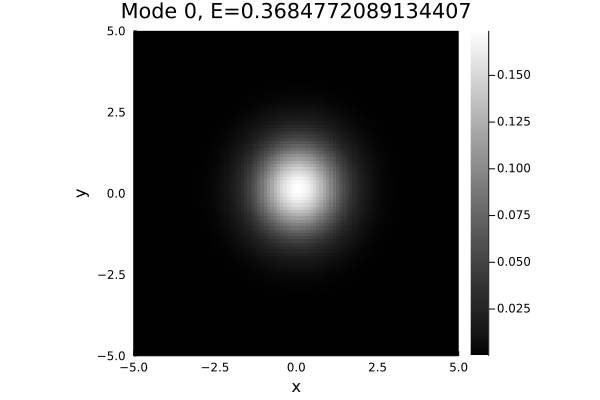

In [441]:
mode = 0;
heatmap(LinRange(xmin,xmax,N),LinRange(ymin,ymax,N), reshape(N/(xmax-xmin)*N/(ymax-ymin)*abs.(lϕk0[mode+1]).^2,N,N)' , xlabel="x", ylabel="y",xlims = (xmin,xmax), ylims=(ymin,ymax),color=:greys, aspect_ratio=:equal ,title = "Mode $(mode), E=$(lEk0[mode+1])")

### 4) Calcul de la correction au premier de cet état non dégénéré avec la perturbation $W$

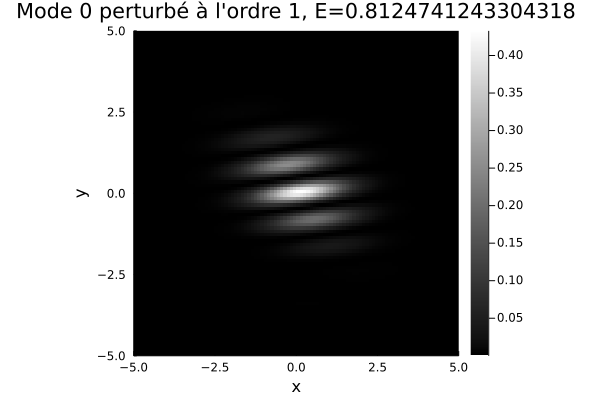

In [442]:
function correction_nd_o1(lϕk0,lEk0,mode,nb_modes,N)
    ϕₙ = copy(lϕk0[mode+1]); # copie du vecteur initial
    Eₙ⁰ = copy(lEk0[mode+1]); # son énergie

    # correction à l'énergie
    Eₙ = Eₙ⁰ + ϕₙ'*W*ϕₙ;
    # correction au vecteur propre
    for i=1:nb_modes
        @views ϕₙ += i==mode+1 ? zeros(N*N) : lϕk0[i]'*W*ϕₙ/(Eₙ⁰-lEk0[i]) * lϕk0[i] # formule B-11 du Cohen-Tanoudji, chapitre 11, page 1127
    end
    ϕₙ = ϕₙ/norm(ϕₙ);
    return Eₙ,ϕₙ
end

Eₙ,ϕₙ = correction_nd_o1(lϕk0,lEk0,mode,nb_modes,N);
heatmap(LinRange(xmin,xmax,N),LinRange(ymin,ymax,N), reshape(N/(xmax-xmin)*N/(ymax-ymin)*abs.(ϕₙ).^2,N,N)' , xlabel="x", ylabel="y",xlims = (xmin,xmax), ylims=(ymin,ymax), color=:greys, aspect_ratio=:equal ,title = "Mode $(mode) perturbé à l'ordre 1, E=$(Eₙ)")

### 5) Calcul de l'état correspondant avec le hamiltonien complet pour comparaison

In [443]:
ϕ =  rand(Float64, N*N); # pour 20 modes sur 200 points, et dimension Krylov de 200, compter environ 40 secondes
nb_modes = 50;
@time lE, lϕk, infos = KrylovKit.eigsolve(H, ϕ, nb_modes, :SR, krylovdim=200); # KrylovKit semble ne trouver que des solutions séparables ici !!
infos

  2.297869 seconds (14.63 k allocations: 258.969 MiB, 1.69% gc time)


ConvergenceInfo: 51 converged values after 16 iterations and 1302 applications of the linear map;
norms of residuals are given by (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.078705670004142e-31, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.3405892411382598e-18, 3.285192535577162e-17, 3.576214208131597e-16, 4.938518079168469e-16, 2.0856121709340882e-15, 1.7013762614589792e-13, 1.495807501785573e-14, 5.119374422266877e-13).


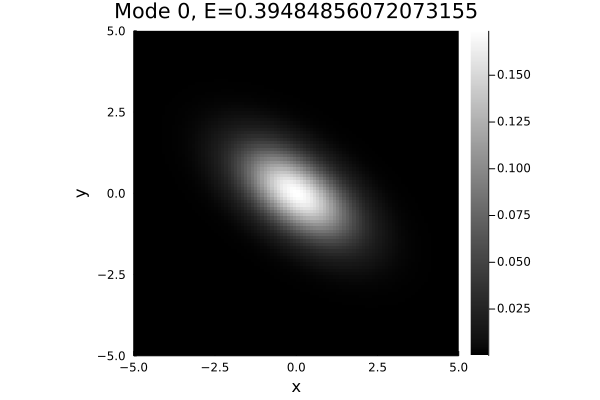

In [444]:
heatmap(LinRange(xmin,xmax,N),LinRange(ymin,ymax,N), reshape(N/(xmax-xmin)*N/(ymax-ymin)*abs.(lϕk[mode+1]).^2,N,N)' , xlabel="x", ylabel="y",xlims = (xmin,xmax), ylims=(ymin,ymax),color=:greys, aspect_ratio=:equal ,title = "Mode $(mode), E=$(lE[mode+1])")

# Brouillon

In [ ]:
using Polynomials, SpecialPolynomials
const SP=SpecialPolynomials
x = variable(Polynomial{Rational{Int}})
H = [basis(Hermite, i)(x) for i in 0:20] # /!\ au décalage d'incice
ϕ1D = (n,x) -> (m*ω/ħ)^(.25)*2^(-n/2)*1/sqrt(factorial(n))*π^(-1/4)*H[n+1](sqrt(m*ω/ħ)*x)*exp(-m*ω/2/ħ*x^2)
ϕ2D = (nₖ, nₗ, x, y) -> sqrt(m*ω/ħ)/sqrt(2^(nₖ+nₗ))/sqrt(factorial(nₖ)*factorial(nₗ))/sqrt(π) * H[nₖ+1](sqrt(m*ω/ħ)*x) * H[nₗ+1](sqrt(m*ω/ħ)*y) * exp(-m*ω/2/ħ*(x^2+y^2))

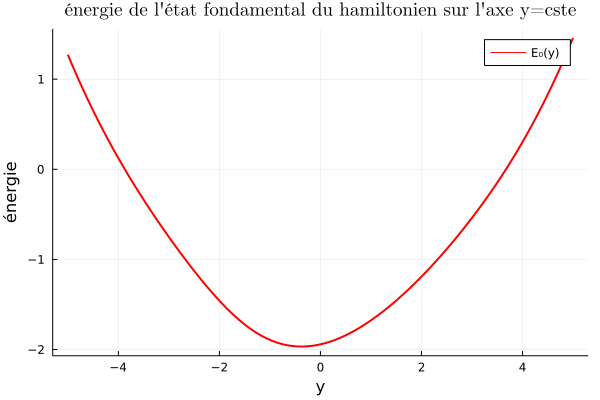

In [100]:
plot(LinRange(ymin,ymax,N), lowest_energies_y, grid=true, w=2, color = "red", linestyle=:solid, label="E₀(y)",
title="énergie de l'état fondamental du hamiltonien sur l'axe y=cste", titlefont=font(12,"Computer Modern"),
xlabel="y",
ylabel="énergie")

  0.011517 seconds (11 allocations: 386.891 KiB)
  0.014550 seconds (14 allocations: 1011.891 KiB)


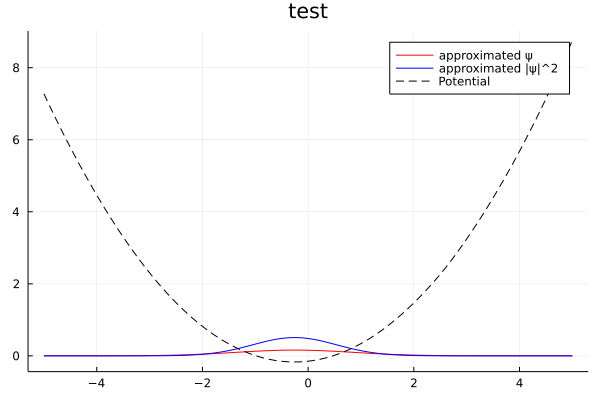

In [246]:
using Plots
using LaTeXStrings

N=200;
xmin = -5; xmax = 5;
Δx = (xmax-xmin)/N;

Λ = 1/Δx^2*SymTridiagonal(-2*ones(Float64,N),ones(Float64,N-1));
V = V_func.(LinRange(xmin,xmax,N),y₀);
𝒱 = sparse(Diagonal(V));
H = Matrix(-ħ^2/2/m*Λ+𝒱);


@time vap = eigvals(H);
@time vep = eigvecs(H); # ils sont normés

nₓ = 0; # nomrbe quantique
axis_range = LinRange(xmin,xmax,N);
plot(axis_range, [vep[:,nₓ+1], N/(xmax-xmin)*abs.(vep[:,nₓ+1]).^2, V], grid=true, w=[1 1 1], color = ["red" "blue" "black"], linestyle=[:solid :solid :dash], label=["approximated ψ" "approximated |ψ|^2" "Potential"], title = "test")

In [151]:
data = [1 20 30; 20 1 60; 30 60 1]

3×3 Matrix{Int64}:
  1  20  30
 20   1  60
 30  60   1